In [1]:
import tweepy
import json
from pymongo import MongoClient
from collections import Counter
from collections.abc import MutableMapping
import logging
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import community
import seaborn as sns
from fastprogress import master_bar, progress_bar
import time
import re

import nltk
#nltk.download()
#nltk.download('stopwords')
from nltk.corpus import stopwords
import advertools as adv


#Logger
logging.basicConfig(filename='Separate-General-Partisan-Keywords.log', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logging.getLogger().addHandler(ch)

In [2]:
##############
# PARAMETERS #
##############

client = MongoClient(username='XXX', password='XXX')

DatabaseName = "Streaming"
tweetCollection = "Campanya-Interactions-ByKeywordType"

db = client[DatabaseName]
tweetCollection = db[tweetCollection]

In [3]:
###############################
#  STOPWORDS && EMOJI PATTERN #
###############################

stopwords_spanish = nltk.corpus.stopwords.words('spanish')
stopwords_english = nltk.corpus.stopwords.words('english')
stopwords_catalan = adv.stopwords['catalan']

custom_stopwords = ['none', '', 'q', 'l', '\n', 'rt']

stopwords = stopwords_spanish + stopwords_english + list(stopwords_catalan)
stopwords.extend(custom_stopwords)

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
                           "]+", flags=re.UNICODE)

In [41]:
####################
# SET KEYWORD LIST #
####################

GENERAL_KEYWORD_LIST = [x.lower() for x in ["#19J", "#19Junio", "#19JAndalucia", "#19JAndalucía", "#Elecciones19J", "19J", 
                                            "19Junio", "#EleccionesAndaluzas", "#EleccionesAndalucia", "#EleccionesAndalucía", 
                                            "#EleccionesAndalucia2022", "#EleccionesAndalucía2022","#DebateRTVE", 
                                            "#ElDebateDecisivo", "#DebateDecisivo"]]

PARTISAN_KEYWORD_LIST = [x.lower() for x in ["#AndaluciaAvanza", "#AndalucíaAvanza", "#JuanmaPresidente", "#SiVotamosGanamos", 
                                             "#AndaluciaQuiereMas", "#AndalucíaQuiereMás", "#VotaPSOE", "#19JAdelante", 
                                             "#AdelanteAndalucia", "#AdelanteAndalucía", "#EnDefensaPropia", 
                                             "#AndaluciaEnDefensaPropia", "#AndalucíaEnDefensaPropia", "#Adelante19J", 
                                             "#VotaAdelante19J", "#CambioReal", "#OlonaPresidenta", "#VotaMacarenazo", 
                                             "#VotaMacarenaPresidenta", "#PorAndalucia", "#PorAndalucía", "#VotaTere19J",
                                             "#AndaluciaLiberal", "#AndalucíaLiberal", "#ElCambioQueFunciona"]]

In [50]:
####################
# GET KEYWORD TYPE #
####################

def clean_tweet(twit_text):
    #twit_text_filtered = re.sub(r'[#@]', '', twit_text)
    twit_text_filtered = twit_text
    twit_text_filtered_2 = re.sub(r'(\s)http\S+', '', twit_text_filtered)
    twit_text_filtered_3 = emoji_pattern.sub(r'', twit_text_filtered_2)
    #twit_text_filtered_3 = twit_text_filtered_2.encode('ascii', 'ignore').decode('ascii') 
    return twit_text_filtered_3

tweets = tweetCollection.find(no_cursor_timeout=True, batch_size=1000000)

print("OK")

for tweet in tweets:

    if 'retweeted_status' in tweet:
        if 'extended_tweet' in tweet['retweeted_status']:
            clean_text = clean_tweet(str(tweet['retweeted_status']['extended_tweet']['full_text']))
        else:
            clean_text = clean_tweet(str(tweet['retweeted_status']['text']))
            
        if tweet['retweeted_status']['is_quote_status']:
            if 'quoted_status' in tweet['retweeted_status']:
                if 'extended_tweet' in tweet['retweeted_status']['quoted_status']:
                    clean_text += " " + clean_tweet(str(tweet['retweeted_status']['quoted_status']['extended_tweet']['full_text']))
                else:
                    clean_text += " " + clean_tweet(str(tweet['retweeted_status']['quoted_status']['text']))
    elif tweet['is_quote_status']:
        if 'extended_tweet' in tweet:
            clean_text = clean_tweet(str(tweet['extended_tweet']['full_text']))
        else:
            clean_text = clean_tweet(str(tweet['text']))
        
        if 'quoted_status' in tweet:
            if 'extended_tweet' in tweet['quoted_status']:
                clean_text += " " + clean_tweet(str(tweet['quoted_status']['extended_tweet']['full_text']))
            else:
                clean_text += " " + clean_tweet(str(tweet['quoted_status']['text']))                  
    elif tweet['in_reply_to_status_id'] is not None:
        if 'extended_tweet' in tweet:
            clean_text = clean_tweet(str(tweet['extended_tweet']['full_text']))
        else:
            clean_text = clean_tweet(str(tweet['text']))
    else:
        if 'extended_tweet' in tweet:
            clean_text = clean_tweet(str(tweet['extended_tweet']['full_text']))
        else:
            clean_text = clean_tweet(str(tweet['text']))
    
    clean_text = clean_text.replace('\n',' ').replace('\t',' ')
    
    tokens = [w.strip('“”.,;:-():!?-‘’|/•&+* ') for w in re.split(r"[ ']+", clean_text.lower())]   
    important_tokens = [important_token for important_token in tokens if important_token not in stopwords]
    
    list_general_keywords = list(set(important_tokens).intersection(GENERAL_KEYWORD_LIST))
    list_partisan_keywords = list(set(important_tokens).intersection(PARTISAN_KEYWORD_LIST))
       
    keyword_type = "?"
    
    if len(list_general_keywords)>0 and len (list_partisan_keywords)>0:
        keyword_type = "BOTH"
    elif len(list_general_keywords)==0 and len (list_partisan_keywords)>0:
        keyword_type = "PARTISAN"
    elif len(list_general_keywords)>0 and len(list_partisan_keywords)==0:
        keyword_type = "GENERAL"
    
    try:
        tweetCollection.update_one(
                                    {'_id': tweet['_id']},
                                    {'$set': 
                                        {
                                            'KEYWORD_TYPE': keyword_type,
                                            'GENERAL_KEYWORDS': list_general_keywords,
                                            'PARTISAN_KEYWORDS': list_partisan_keywords
                                        }
                                    },
                                    upsert=False,
                                  )
    
    except Exception as e:
        logging.error(e)
        logging.error("Fatal exception inserting users in MongoDB")

OK


In [60]:
##########################
# TWEETS BY KEYWORD TYPE #
##########################

def load_tweets(collection):
    """Extracts the tweet bot interaction information
    
    Keyword arguments:
    collection -- MongoDB Tweets' Collection
    """
    pipeline = [
                {
                    '$project': {
                        'KEYWORD_TYPE': True
                    }
                }, {
                    '$group': {
                        '_id': {'KEYWORD_TYPE':'$KEYWORD_TYPE'}, 
                        'count': {
                            '$sum': 1
                        }
                    }
                }
            ]
    print("Query", end=" ")
    tweets = collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    tweets = list(tweets)
    print("OK; Total combinations:", len(tweets))
    return tweets

tweets = load_tweets(tweetCollection)
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.concat([pd.json_normalize(tweets_df['_id']), tweets_df['count']], axis=1)

totalTweets = tweets_df2['count'].sum()
print("TOTAL TWEETS: " + str(totalTweets))

print(tweets_df2.sort_values('count', ascending=False).to_string(index=False))

Query OK; List OK; Total combinations: 4
TOTAL TWEETS: 1532850
KEYWORD_TYPE  count
    PARTISAN 827771
     GENERAL 393090
        BOTH 303402
           ?   8587


In [61]:
##########################################################
# EXTRACT DATA INTERACTIONS BY COMMUNITY AND KEYWORD TYPE#
##########################################################

def load_tweets(collection):
    """Extracts the tweet community interaction information
    
    Keyword arguments:
    collection -- MongoDB Tweets' Collection
    """
    pipeline = [
                {
                    '$project': {
                        'ACTIVE_community': True,
                        'KEYWORD_TYPE': True
                    }
                }, {
                    '$group': {
                        '_id': {'ACTIVE_community':'$ACTIVE_community', 'KEYWORD_TYPE':'$KEYWORD_TYPE'}, 
                        'count': {
                            '$sum': 1
                        }
                    }
                }
            ]
    print("Query", end=" ")
    tweets = collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    tweets = list(tweets)
    print("OK; Total combinations:", len(tweets))
    return tweets

tweets = load_tweets(tweetCollection)
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.concat([pd.json_normalize(tweets_df['_id']), tweets_df['count']], axis=1)

totalTweets = tweets_df2['count'].sum()
print("TOTAL TWEETS: " + str(totalTweets))

print(tweets_df2.sort_values('count', ascending=False).head(30).to_string(index=False))

tweets_df3 = tweets_df2.groupby(['ACTIVE_community', 'KEYWORD_TYPE']).agg({'count': 'sum'})
tweets_df4 = tweets_df3.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

print(tweets_df4.sort_values('ACTIVE_community').to_string())

Query OK; List OK; Total combinations: 54
TOTAL TWEETS: 1532850
ACTIVE_community KEYWORD_TYPE  count
             VOX     PARTISAN 379814
            PSOE     PARTISAN 179200
         POR_AND     PARTISAN 150454
         POR_AND      GENERAL 122021
             VOX      GENERAL 111238
            PSOE         BOTH 108246
         POR_AND         BOTH  71001
             VOX         BOTH  60051
              PP     PARTISAN  54766
            PSOE      GENERAL  30945
              PP         BOTH  27967
    ADELANTE_AND      GENERAL  23268
        COLOMBIA      GENERAL  21279
            NONE      GENERAL  19023
    ADELANTE_AND     PARTISAN  19012
             ???     PARTISAN  17907
              PP      GENERAL  17806
              CS     PARTISAN  16365
              CS      GENERAL  12640
            NONE         BOTH  12146
    ADELANTE_AND         BOTH  11932
        R0+ALTER      GENERAL  10656
           MEDIA      GENERAL  10472
              CS         BOTH  10246
           

In [62]:
########################################
# TWEETS BY SUP_COMMUNITY INTERACTIONS AND KEYWORD #
########################################

def load_tweets(collection):
    """Extracts the tweet bot interaction information
    
    Keyword arguments:
    collection -- MongoDB Tweets' Collection
    """
    pipeline = [
                {
                    '$project': {
                        'SUP_community_active': True,
                        'KEYWORD_TYPE': True
                    }
                }, {
                    '$group': {
                        '_id': {'SUP_community_active':'$SUP_community_active', 'KEYWORD_TYPE':'$KEYWORD_TYPE'}, 
                        'count': {
                            '$sum': 1
                        }
                    }
                }
            ]
    print("Query", end=" ")
    tweets = collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    tweets = list(tweets)
    print("OK; Total combinations:", len(tweets))
    return tweets

tweets = load_tweets(tweetCollection)
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.concat([pd.json_normalize(tweets_df['_id']), tweets_df['count']], axis=1)

totalTweets = tweets_df2['count'].sum()
print("TOTAL TWEETS: " + str(totalTweets))

print(tweets_df2.sort_values('count', ascending=False).to_string(index=False))

Query OK; List OK; Total combinations: 12
TOTAL TWEETS: 1532850
SUP_community_active KEYWORD_TYPE  count
               RIGHT     PARTISAN 450945
                LEFT     PARTISAN 348666
                LEFT         BOTH 191179
                LEFT      GENERAL 176234
               RIGHT      GENERAL 141684
               RIGHT         BOTH  98264
                   ?      GENERAL  75172
                   ?     PARTISAN  28160
                   ?         BOTH  13959
               RIGHT            ?   4127
                LEFT            ?   3140
                   ?            ?   1320


In [75]:
##########################################################
# EXTRACT DATA INTERACTIONS BY COMMUNITY (BY TWEET TYPE) #
##########################################################

tweetType = "PARTISAN"

def load_tweets(collection):
    """Extracts the tweet community interaction information
    
    Keyword arguments:
    collection -- MongoDB Tweets' Collection
    """
    pipeline = [
                {
                    '$match': {
                        'KEYWORD_TYPE': tweetType
                    }
                },{
                    '$project': {
                        'ACTIVE_community': True,
                        'PASSIVE_community': True
                    }
                }, {
                    '$group': {
                        '_id': {'ACTIVE_community':'$ACTIVE_community', 'PASSIVE_community':'$PASSIVE_community'}, 
                        'count': {
                            '$sum': 1
                        }
                    }
                }
            ]
    print("Query", end=" ")
    tweets = collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    tweets = list(tweets)
    print("OK; Total combinations:", len(tweets))
    return tweets

tweets = load_tweets(tweetCollection)
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.concat([pd.json_normalize(tweets_df['_id']), tweets_df['count']], axis=1)

totalTweets = tweets_df2['count'].sum()
print("TOTAL TWEETS: " + str(totalTweets))

print(tweets_df2.sort_values('count', ascending=False).head(30).to_string(index=False))

tweets_df3 = tweets_df2.groupby(['ACTIVE_community', 'PASSIVE_community']).agg({'count': 'sum'})
tweets_df4 = tweets_df3.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

print(tweets_df4.sort_values('ACTIVE_community').to_string())

Query OK; List OK; Total combinations: 145
TOTAL TWEETS: 827771
ACTIVE_community PASSIVE_community  count
             VOX               VOX 372663
            PSOE              PSOE 170542
         POR_AND           POR_AND 138716
              PP                PP  52078
    ADELANTE_AND      ADELANTE_AND  16596
              CS                CS  15598
             ???               ???  15217
         POR_AND              PSOE   7162
            PSOE           POR_AND   6606
            NONE              NONE   2896
             VOX              PSOE   2350
         POR_AND               ???   1877
        COLOMBIA          COLOMBIA   1806
              PP               VOX   1729
             VOX                PP   1624
             ???               VOX   1575
           MEDIA             MEDIA   1258
    ADELANTE_AND           POR_AND   1093
         POR_AND               VOX    998
             VOX               ???    993
         POR_AND      ADELANTE_AND    977
            

In [76]:
########################
# PREPARE HEATMAP DATA #
########################

COMMUNITIES_LIST = ["VOX", "POR_AND", "PSOE", "PP", "ADELANTE_AND", "CS"]

def load_tweets(collection):
    """Extracts the tweet community interaction information
    
    Keyword arguments:
    collection -- MongoDB Tweets' Collection
    """
    pipeline = [
                {
                    '$match': {
                        'KEYWORD_TYPE': tweetType
                    }
                },{
                    '$project': {
                        'ACTIVE_community': True,
                        'PASSIVE_community': True
                    }
                }, {
                    '$group': {
                        '_id': {'ACTIVE_community':'$ACTIVE_community', 'PASSIVE_community':'$PASSIVE_community'}, 
                        'count': {
                            '$sum': 1
                        }
                    }
                }
            ]
    print("Query", end=" ")
    tweets = collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    tweets = list(tweets)
    print("OK; Total combinations:", len(tweets))
    return tweets

tweets = load_tweets(tweetCollection)
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.concat([pd.json_normalize(tweets_df['_id']), tweets_df['count']], axis=1)

totalTweets = tweets_df2['count'].sum()
print("TOTAL TWEETS: " + str(totalTweets))

tweets_df3 = tweets_df2[tweets_df2['ACTIVE_community'].isin(COMMUNITIES_LIST)]
tweets_df4 = tweets_df3[tweets_df3['PASSIVE_community'].isin(COMMUNITIES_LIST)]

#print(tweets_df4.sort_values('count', ascending=False).to_string(index=False))

tweets_df5 = tweets_df4.groupby(['ACTIVE_community', 'PASSIVE_community']).agg({'count': 'sum'})
tweets_df_test = tweets_df5.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

print(tweets_df_test.sort_values('ACTIVE_community').to_string())

tweets_df_test = tweets_df_test.reset_index()  
print(tweets_df_test)

Query OK; List OK; Total combinations: 145
TOTAL TWEETS: 827771
                                        count
ACTIVE_community PASSIVE_community           
ADELANTE_AND     ADELANTE_AND       90.004881
                 CS                  0.108466
                 POR_AND             5.927653
                 PP                  0.645371
                 PSOE                1.079234
                 VOX                 2.234394
CS               ADELANTE_AND        0.178023
                 CS                 95.751995
                 POR_AND             0.478821
                 PP                  0.724371
                 PSOE                0.779619
                 VOX                 2.087170
POR_AND          PSOE                4.826276
                 PP                  0.332219
                 VOX                 0.672525
                 CS                  0.033694
                 ADELANTE_AND        0.658374
                 POR_AND            93.476913
PP              

In [78]:
##########################
# PREPARE HEATMAP DATA 2 #
##########################

#print(tweets_df_test.index[0])
#print(tweets_df_test.name)
index_active = COMMUNITIES_LIST
index_passive = COMMUNITIES_LIST

total_index = list(set(index_active+index_passive))

#print(index_active)
#print(index_passive)

total_index_clean = [x for x in total_index if str(x) != 'nan']

final_index = sorted(total_index_clean)

print(final_index)


matrix = np.zeros((len(final_index),len(final_index)))

for active in final_index:
    for passive in final_index:
        #print(active)
        #print(passive)
        value = tweets_df_test[(tweets_df_test["ACTIVE_community"]==active) & (tweets_df_test["PASSIVE_community"]==passive)]["count"]
        matrix[final_index.index(active)][final_index.index(passive)] = value

print(matrix)

['ADELANTE_AND', 'CS', 'POR_AND', 'PP', 'PSOE', 'VOX']
[[9.00048810e+01 1.08465752e-01 5.92765334e+00 6.45371224e-01
  1.07923423e+00 2.23439449e+00]
 [1.78023327e-01 9.57519951e+01 4.78821363e-01 7.24370780e-01
  7.79619398e-01 2.08717004e+00]
 [6.58373541e-01 3.36936306e-02 9.34769131e+01 3.32219197e-01
  4.82627564e+00 6.72524866e-01]
 [2.56452529e-02 1.55703321e-01 1.75853163e-01 9.53966771e+01
  1.07893242e+00 3.16718873e+00]
 [1.19695504e-01 3.63561109e-02 3.69489952e+00 2.77425092e-01
  9.53883672e+01 4.83256613e-01]
 [2.99036731e-02 8.38890653e-02 2.15147666e-01 4.29766063e-01
  6.21890547e-01 9.86194030e+01]]


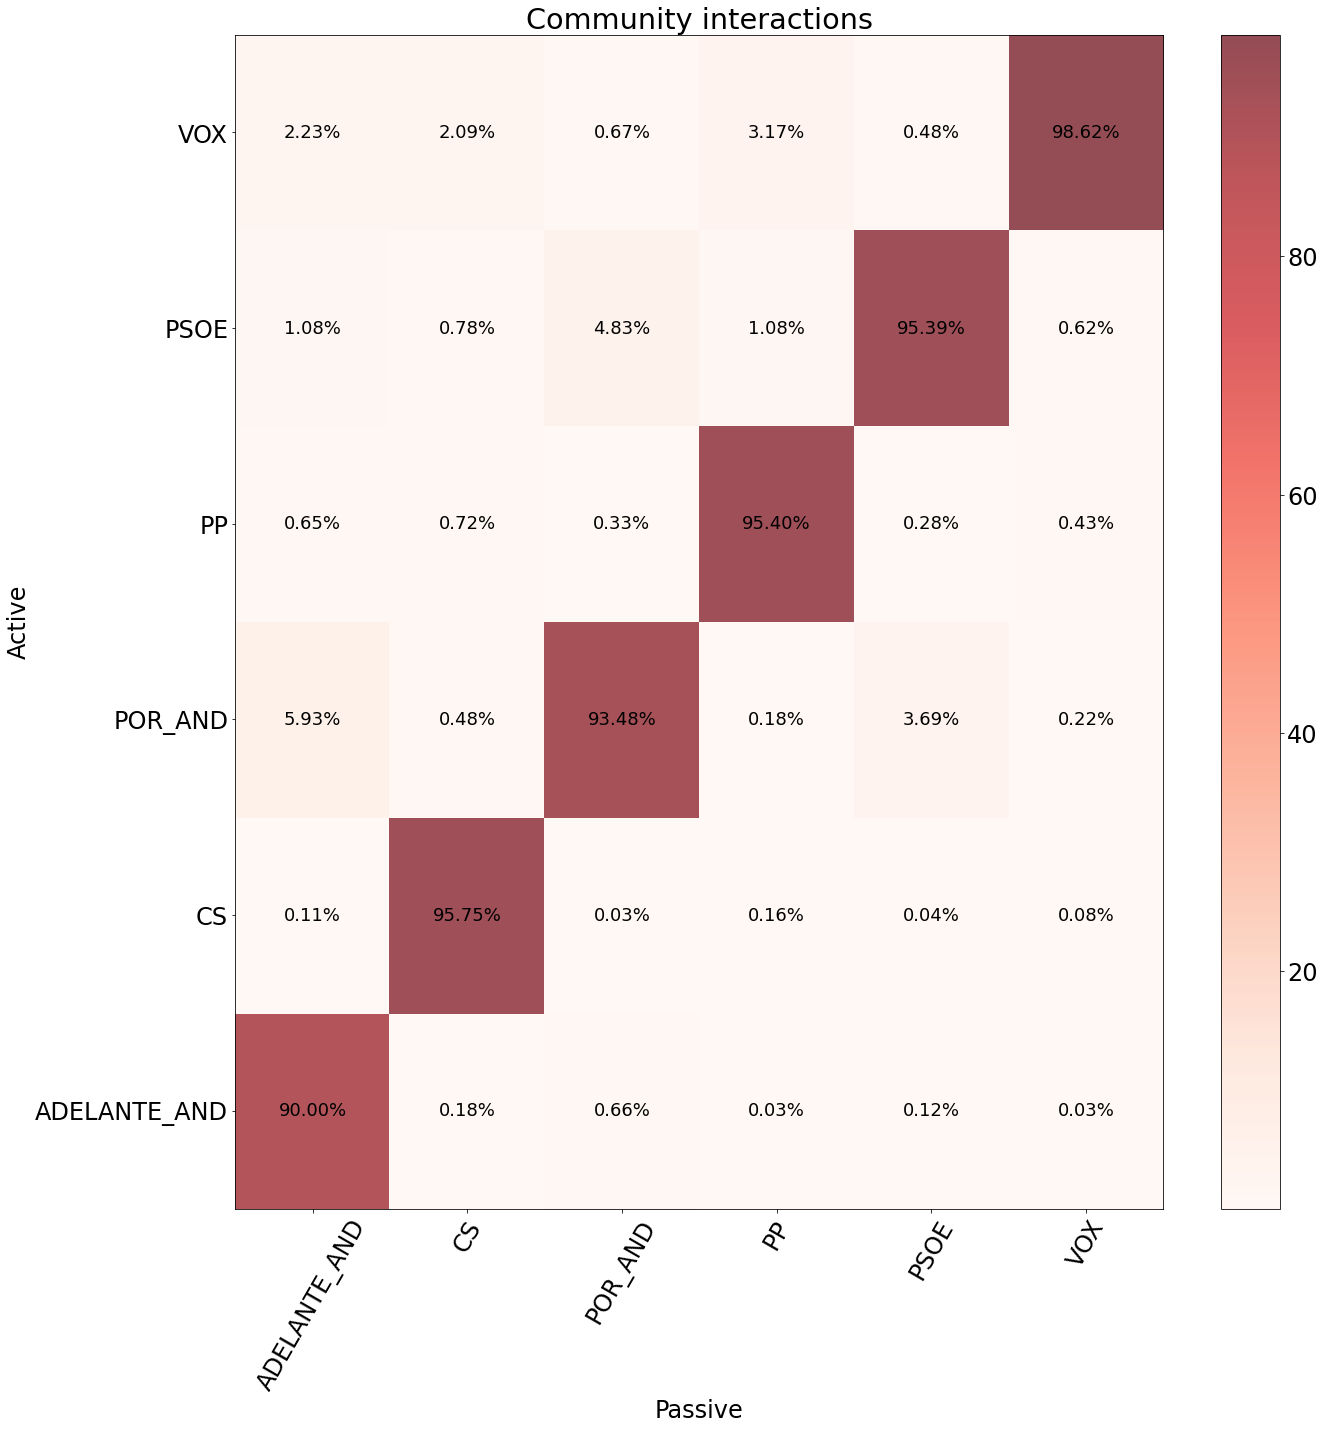

In [79]:
################
# PLOT HEATMAP #
################

def plot_heatmap(m, x_values, y_values, title, xlabel, ylabel, save_fig=False, label_rotation=None):
    """
        Creates a heatmap image from a numpy matrix.

    :param m: 2-dimensional numpy matrix with values to plot
    :param x_values: list of strings for xticks
    :param y_values: list of strings for yticks
    :param title: string, title of the plot
    :param xlabel: string, label of the x axis
    :param ylabel: string, label of the y axis
    :param save_fig: False / "show" / figname , do not show imatge / show it inline / write it to pdf (figure name)
    :param label_rotation: None / int, whether to rotate x ticks (degrees)
    :return:
    """
    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)

    im = ax.imshow(m.transpose(), origin='lower', cmap='Reds', alpha=0.7, aspect='auto')
    #im = ax.imshow(m.transpose(), origin='lower', cmap='jet', alpha=0.7)

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    # Loop over data dimensions and create text annotations.
    mt = m.transpose()
    for i in range(len(x_values)):
        for j in range(len(y_values)):
            text = ax.text(j, i, "{:.2f}%".format(mt[i, j]), ha="center", va="center", color="black", alpha=1, fontsize=18)

    # Named ticks
    ax.set_xticks(np.arange(len(x_values)))
    ax.set_yticks(np.arange(len(y_values)))
    ax.set_xticklabels(x_values)
    ax.set_yticklabels(y_values)

    # Axis labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Rotate x labels
    if label_rotation:
        plt.xticks(rotation=label_rotation)

    fig.tight_layout()
    plt.title(title)
    
    plt.rcParams.update({'font.size': 24})

    # Output result
    if not save_fig:
        pass
    elif save_fig == "show":
        plt.show()
    else:
        plt.savefig(save_fig + '.pdf', format='pdf', dpi=600)
        plt.close()

        
######INPUT DATA#####

m = matrix
x_values = final_index
y_values = final_index
title = "Community interactions"
xlabel = "Passive"
ylabel = "Active"
save_fig = "show"

plot_heatmap(m, x_values, y_values, title, xlabel, ylabel, save_fig, 60)

In [80]:
########################################
# TWEETS BY SUP_COMMUNITY INTERACTIONS #
########################################

def load_tweets(collection):
    """Extracts the tweet bot interaction information
    
    Keyword arguments:
    collection -- MongoDB Tweets' Collection
    """
    pipeline = [
                {
                    '$match': {
                        'KEYWORD_TYPE': tweetType
                    }
                },{
                    '$project': {
                        'SUP_community_active': True,
                        'SUP_community_passive': True
                    }
                }, {
                    '$group': {
                        '_id': {'SUP_community_active':'$SUP_community_active', 'SUP_community_passive':'$SUP_community_passive'}, 
                        'count': {
                            '$sum': 1
                        }
                    }
                }
            ]
    print("Query", end=" ")
    tweets = collection.aggregate(pipeline, allowDiskUse=True)
    print("OK; List", end=" ")
    tweets = list(tweets)
    print("OK; Total combinations:", len(tweets))
    return tweets

tweets = load_tweets(tweetCollection)
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.concat([pd.json_normalize(tweets_df['_id']), tweets_df['count']], axis=1)

totalTweets = tweets_df2['count'].sum()
print("TOTAL TWEETS: " + str(totalTweets))

print(tweets_df2.sort_values('count', ascending=False).to_string(index=False))

Query OK; List OK; Total combinations: 9
TOTAL TWEETS: 827771
SUP_community_active SUP_community_passive  count
               RIGHT                 RIGHT 444552
                LEFT                  LEFT 342105
                   ?                     ?  22127
               RIGHT                  LEFT   4209
                   ?                 RIGHT   3682
                LEFT                 RIGHT   3517
                LEFT                     ?   3044
                   ?                  LEFT   2351
               RIGHT                     ?   2184
